# Packages

In [1]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

# Configuration

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 25
batch_size = 25
min_freq = 0

num_epochs = 100

max_lr_dec = 3
lr_dec = 0

# Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [6]:
!wget --quiet --continue https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -q wikitext-2-v1.zip
!cd wikitext-2 && mv wiki.train.tokens train.txt
!cd wikitext-2 && mv wiki.valid.tokens valid.txt
!cd wikitext-2 && mv wiki.test.tokens test.txt

### load dataset file

In [11]:
char2ind = {}
def data_init():
    global char2ind
    with open("./wikitext-2/train.txt", encoding="utf8") as f:
        file = f.read()
        trn = file[1:].split(' ')
    with open("./wikitext-2/valid.txt", encoding="utf8") as f:
        file = f.read()
        vld = file[1:].split(' ')
    with open("./wikitext-2/test.txt", encoding="utf8") as f:
        file = f.read()
        tst = file[1:].split(' ')
    words = sorted(set(trn))
    char2ind = {c: i for i, c in enumerate(words)}
    trn = [char2ind[c] for c in trn]
    vld = [char2ind[c] for c in vld]
    tst = [char2ind[c] for c in tst]
    return torch.tensor(trn,dtype=torch.int64), torch.tensor(vld,dtype=torch.int64), torch.tensor(tst,dtype=torch.int64), len(words)

def findWordByToken(iToken):
    for word, toekn in char2ind.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
        if toekn == iToken:
            return word
    return ''

In [12]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

In [13]:
train_tokens_voc , valid_tokens_voc , test_tokens_voc , vocab_size= data_init()

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)

# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [14]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, _ = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, _ = self.rnn2(output)
    output = self.dropout2(output)
    
    output, _ = self.rnn3(output)
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output


# Train

## Learning Functions

In [15]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [16]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [17]:
embedding_dim = 500
hidden_dim = 500
num_layers = 1
dropout_rate = 0.25


model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
model = model.to(device)

loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0

model

H_LSTM(
  (embedding): Embedding(33278, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33278, bias=True)
)

In [18]:
num_trainable_params(model)

39.323278

## Learning Loop

In [19]:

lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [20]:
num_epochs = 300
max_lr_dec = 5
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

  0%|          | 0/3342 [00:00<?, ?batch/s]/tmp/ipykernel_15991/1059837893.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input), torch.tensor(target)
Epoch 0: 100%|██████████| 3342/3342 [01:18<00:00, 42.82batch/s, loss=6.37, perplexity=755]    


Valid: Loss = 5.782 Perplexity= 336.5, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 3342/3342 [01:14<00:00, 45.04batch/s, loss=5.81, perplexity=349]


Valid: Loss = 5.559 Perplexity= 269.7, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 3342/3342 [01:09<00:00, 47.86batch/s, loss=5.59, perplexity=281]


Valid: Loss = 5.443 Perplexity= 240.6, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 3342/3342 [01:09<00:00, 48.43batch/s, loss=5.44, perplexity=242]


Valid: Loss = 5.374 Perplexity= 225.1, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 3342/3342 [01:08<00:00, 48.47batch/s, loss=5.33, perplexity=217]


Valid: Loss = 5.33 Perplexity= 215.7, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 3342/3342 [01:10<00:00, 47.48batch/s, loss=5.24, perplexity=198]


Valid: Loss = 5.292 Perplexity= 208.0, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 3342/3342 [01:09<00:00, 47.99batch/s, loss=5.16, perplexity=183]


Valid: Loss = 5.277 Perplexity= 205.5, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 3342/3342 [01:08<00:00, 48.50batch/s, loss=5.09, perplexity=171]


Valid: Loss = 5.267 Perplexity= 203.6, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 3342/3342 [01:09<00:00, 47.99batch/s, loss=5.02, perplexity=161]


Valid: Loss = 5.251 Perplexity= 200.4, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 3342/3342 [01:09<00:00, 47.95batch/s, loss=4.97, perplexity=152]


Valid: Loss = 5.237 Perplexity= 197.7, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 3342/3342 [01:09<00:00, 47.90batch/s, loss=4.91, perplexity=144]


Valid: Loss = 5.222 Perplexity= 194.7, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 3342/3342 [01:09<00:00, 48.27batch/s, loss=4.86, perplexity=137]


Valid: Loss = 5.212 Perplexity= 192.7, LR = 0.5
Model Saved!



Epoch 12: 100%|██████████| 3342/3342 [01:09<00:00, 48.13batch/s, loss=4.81, perplexity=130]


Valid: Loss = 5.189 Perplexity= 188.4, LR = 0.5
Model Saved!



Epoch 13: 100%|██████████| 3342/3342 [01:09<00:00, 48.00batch/s, loss=4.77, perplexity=125]


Valid: Loss = 5.176 Perplexity= 185.8, LR = 0.5
Model Saved!



Epoch 14: 100%|██████████| 3342/3342 [01:09<00:00, 48.12batch/s, loss=4.73, perplexity=120]


Valid: Loss = 5.161 Perplexity= 183.2, LR = 0.5
Model Saved!



Epoch 15: 100%|██████████| 3342/3342 [01:08<00:00, 48.56batch/s, loss=4.7, perplexity=116] 


Valid: Loss = 5.168 Perplexity= 184.5, LR = 0.5



Epoch 16: 100%|██████████| 3342/3342 [01:08<00:00, 48.45batch/s, loss=4.55, perplexity=100]


Valid: Loss = 5.068 Perplexity= 167.2, LR = 0.25
Model Saved!



Epoch 17: 100%|██████████| 3342/3342 [01:09<00:00, 48.21batch/s, loss=4.48, perplexity=93.2]


Valid: Loss = 5.067 Perplexity= 167.3, LR = 0.25



Epoch 18: 100%|██████████| 3342/3342 [01:09<00:00, 47.99batch/s, loss=4.42, perplexity=88.1]


Valid: Loss = 5.029 Perplexity= 161.4, LR = 0.125
Model Saved!



Epoch 19: 100%|██████████| 3342/3342 [01:09<00:00, 47.92batch/s, loss=4.36, perplexity=83]  


Valid: Loss = 5.018 Perplexity= 159.9, LR = 0.125
Model Saved!



Epoch 20: 100%|██████████| 3342/3342 [01:09<00:00, 48.09batch/s, loss=4.32, perplexity=79.8]


Valid: Loss = 5.023 Perplexity= 160.7, LR = 0.125



Epoch 21: 100%|██████████| 3342/3342 [01:10<00:00, 47.37batch/s, loss=4.3, perplexity=78.3] 


Valid: Loss = 4.973 Perplexity= 152.9, LR = 0.0625
Model Saved!



Epoch 22: 100%|██████████| 3342/3342 [01:08<00:00, 48.65batch/s, loss=4.26, perplexity=75.6]


Valid: Loss = 4.97 Perplexity= 152.6, LR = 0.0625
Model Saved!



Epoch 23: 100%|██████████| 3342/3342 [01:08<00:00, 48.66batch/s, loss=4.24, perplexity=73.6]


Valid: Loss = 4.968 Perplexity= 152.3, LR = 0.0625
Model Saved!



Epoch 24: 100%|██████████| 3342/3342 [01:10<00:00, 47.64batch/s, loss=4.22, perplexity=72]  


Valid: Loss = 4.967 Perplexity= 152.1, LR = 0.0625
Model Saved!



Epoch 25: 100%|██████████| 3342/3342 [01:09<00:00, 48.03batch/s, loss=4.2, perplexity=70.6] 


Valid: Loss = 4.968 Perplexity= 152.5, LR = 0.0625



Epoch 26: 100%|██████████| 3342/3342 [01:10<00:00, 47.53batch/s, loss=4.19, perplexity=70.2]


Valid: Loss = 4.938 Perplexity= 148.0, LR = 0.03125
Model Saved!



Epoch 27: 100%|██████████| 3342/3342 [01:09<00:00, 48.35batch/s, loss=4.17, perplexity=68.9]


Valid: Loss = 4.938 Perplexity= 148.0, LR = 0.03125



Epoch 28: 100%|██████████| 3342/3342 [01:09<00:00, 47.92batch/s, loss=4.18, perplexity=69.7]


Valid: Loss = 4.905 Perplexity= 143.2, LR = 0.015625
Model Saved!



Epoch 29: 100%|██████████| 3342/3342 [01:10<00:00, 47.68batch/s, loss=4.17, perplexity=68.9]


Valid: Loss = 4.904 Perplexity= 143.0, LR = 0.015625
Model Saved!



Epoch 30: 100%|██████████| 3342/3342 [01:09<00:00, 48.15batch/s, loss=4.16, perplexity=68.2]


Valid: Loss = 4.903 Perplexity= 142.8, LR = 0.015625
Model Saved!



Epoch 31: 100%|██████████| 3342/3342 [01:11<00:00, 46.85batch/s, loss=4.15, perplexity=67.5]


Valid: Loss = 4.9 Perplexity= 142.4, LR = 0.015625
Model Saved!



Epoch 32: 100%|██████████| 3342/3342 [01:10<00:00, 47.54batch/s, loss=4.14, perplexity=67]  


Valid: Loss = 4.901 Perplexity= 142.6, LR = 0.015625



Epoch 33: 100%|██████████| 3342/3342 [01:10<00:00, 47.42batch/s, loss=4.16, perplexity=67.9]


Valid: Loss = 4.88 Perplexity= 139.5, LR = 0.0078125
Model Saved!



Epoch 34: 100%|██████████| 3342/3342 [01:09<00:00, 48.20batch/s, loss=4.15, perplexity=67.5]


Valid: Loss = 4.879 Perplexity= 139.4, LR = 0.0078125
Model Saved!



Epoch 35: 100%|██████████| 3342/3342 [01:10<00:00, 47.45batch/s, loss=4.15, perplexity=67.1]


Valid: Loss = 4.878 Perplexity= 139.3, LR = 0.0078125
Model Saved!



Epoch 36: 100%|██████████| 3342/3342 [01:10<00:00, 47.31batch/s, loss=4.14, perplexity=66.9]


Valid: Loss = 4.877 Perplexity= 139.2, LR = 0.0078125
Model Saved!



Epoch 37: 100%|██████████| 3342/3342 [01:10<00:00, 47.71batch/s, loss=4.14, perplexity=66.5]


Valid: Loss = 4.878 Perplexity= 139.3, LR = 0.0078125



Epoch 38: 100%|██████████| 3342/3342 [01:10<00:00, 47.31batch/s, loss=4.15, perplexity=67.4]


Valid: Loss = 4.867 Perplexity= 137.9, LR = 0.00390625
Model Saved!



Epoch 39: 100%|██████████| 3342/3342 [01:10<00:00, 47.11batch/s, loss=4.14, perplexity=67.1]


Valid: Loss = 4.866 Perplexity= 137.6, LR = 0.00390625
Model Saved!



Epoch 40: 100%|██████████| 3342/3342 [01:09<00:00, 47.79batch/s, loss=4.14, perplexity=66.9]


Valid: Loss = 4.866 Perplexity= 137.6, LR = 0.00390625



Epoch 41: 100%|██████████| 3342/3342 [01:09<00:00, 47.88batch/s, loss=4.15, perplexity=67.4]


Valid: Loss = 4.86 Perplexity= 136.8, LR = 0.001953125
Model Saved!



Epoch 42: 100%|██████████| 3342/3342 [01:11<00:00, 46.80batch/s, loss=4.14, perplexity=67]  


Valid: Loss = 4.859 Perplexity= 136.8, LR = 0.001953125
Model Saved!



Epoch 43: 100%|██████████| 3342/3342 [01:10<00:00, 47.14batch/s, loss=4.14, perplexity=66.8]


Valid: Loss = 4.859 Perplexity= 136.7, LR = 0.001953125
Model Saved!



Epoch 44: 100%|██████████| 3342/3342 [01:10<00:00, 47.56batch/s, loss=4.14, perplexity=66.7]


Valid: Loss = 4.858 Perplexity= 136.6, LR = 0.001953125
Model Saved!



Epoch 45: 100%|██████████| 3342/3342 [01:17<00:00, 43.28batch/s, loss=4.14, perplexity=66.6]


Valid: Loss = 4.858 Perplexity= 136.6, LR = 0.001953125
Model Saved!



Epoch 46: 100%|██████████| 3342/3342 [01:17<00:00, 43.22batch/s, loss=4.14, perplexity=66.5]


Valid: Loss = 4.858 Perplexity= 136.5, LR = 0.001953125
Model Saved!



Epoch 47: 100%|██████████| 3342/3342 [01:16<00:00, 43.52batch/s, loss=4.13, perplexity=66.4]


Valid: Loss = 4.857 Perplexity= 136.5, LR = 0.001953125
Model Saved!



Epoch 48: 100%|██████████| 3342/3342 [01:14<00:00, 44.85batch/s, loss=4.13, perplexity=66.3]


Valid: Loss = 4.857 Perplexity= 136.5, LR = 0.001953125
Model Saved!



Epoch 49: 100%|██████████| 3342/3342 [01:10<00:00, 47.43batch/s, loss=4.13, perplexity=66.2]


Valid: Loss = 4.857 Perplexity= 136.5, LR = 0.001953125



Epoch 50: 100%|██████████| 3342/3342 [01:11<00:00, 46.94batch/s, loss=4.13, perplexity=66.3]


Valid: Loss = 4.854 Perplexity= 136.1, LR = 0.0009765625
Model Saved!



Epoch 51: 100%|██████████| 3342/3342 [01:10<00:00, 47.13batch/s, loss=4.13, perplexity=66.2]


Valid: Loss = 4.853 Perplexity= 135.9, LR = 0.0009765625
Model Saved!



Epoch 52: 100%|██████████| 3342/3342 [01:10<00:00, 47.31batch/s, loss=4.13, perplexity=66.2]


Valid: Loss = 4.853 Perplexity= 135.9, LR = 0.0009765625
Model Saved!



Epoch 53: 100%|██████████| 3342/3342 [01:10<00:00, 47.27batch/s, loss=4.13, perplexity=66.1]


Valid: Loss = 4.853 Perplexity= 135.9, LR = 0.0009765625
Model Saved!



Epoch 54: 100%|██████████| 3342/3342 [01:11<00:00, 46.82batch/s, loss=4.13, perplexity=66]  


Valid: Loss = 4.853 Perplexity= 135.9, LR = 0.0009765625
Model Saved!



Epoch 55: 100%|██████████| 3342/3342 [01:10<00:00, 47.40batch/s, loss=4.13, perplexity=65.9]


Valid: Loss = 4.853 Perplexity= 135.9, LR = 0.0009765625



Epoch 56: 100%|██████████| 3342/3342 [01:11<00:00, 46.97batch/s, loss=4.13, perplexity=66]  


Valid: Loss = 4.851 Perplexity= 135.6, LR = 0.00048828125
Model Saved!



Epoch 57: 100%|██████████| 3342/3342 [01:09<00:00, 47.82batch/s, loss=4.13, perplexity=65.8]


Valid: Loss = 4.851 Perplexity= 135.6, LR = 0.00048828125
Model Saved!



Epoch 58: 100%|██████████| 3342/3342 [01:11<00:00, 46.68batch/s, loss=4.13, perplexity=65.8]


Valid: Loss = 4.851 Perplexity= 135.6, LR = 0.00048828125
Model Saved!



Epoch 59: 100%|██████████| 3342/3342 [01:10<00:00, 47.24batch/s, loss=4.13, perplexity=65.8]


Valid: Loss = 4.85 Perplexity= 135.6, LR = 0.00048828125
Model Saved!



Epoch 60: 100%|██████████| 3342/3342 [01:11<00:00, 46.62batch/s, loss=4.13, perplexity=65.8]


Valid: Loss = 4.85 Perplexity= 135.5, LR = 0.00048828125
Model Saved!



Epoch 61: 100%|██████████| 3342/3342 [01:10<00:00, 47.29batch/s, loss=4.12, perplexity=65.8]


Valid: Loss = 4.85 Perplexity= 135.5, LR = 0.00048828125
Model Saved!



Epoch 62: 100%|██████████| 3342/3342 [01:10<00:00, 47.13batch/s, loss=4.12, perplexity=65.7]


Valid: Loss = 4.85 Perplexity= 135.6, LR = 0.00048828125



Epoch 63: 100%|██████████| 3342/3342 [01:10<00:00, 47.08batch/s, loss=4.12, perplexity=65.7]


Valid: Loss = 4.85 Perplexity= 135.4, LR = 0.000244140625
Model Saved!



Epoch 64: 100%|██████████| 3342/3342 [01:11<00:00, 46.93batch/s, loss=4.12, perplexity=65.7]


Valid: Loss = 4.849 Perplexity= 135.4, LR = 0.000244140625
Model Saved!



Epoch 65: 100%|██████████| 3342/3342 [01:10<00:00, 47.61batch/s, loss=4.12, perplexity=65.7]


Valid: Loss = 4.849 Perplexity= 135.4, LR = 0.000244140625
Model Saved!



Epoch 66: 100%|██████████| 3342/3342 [01:10<00:00, 47.22batch/s, loss=4.12, perplexity=65.7]


Valid: Loss = 4.849 Perplexity= 135.4, LR = 0.000244140625
Model Saved!



Epoch 67: 100%|██████████| 3342/3342 [01:11<00:00, 46.93batch/s, loss=4.12, perplexity=65.7]


Valid: Loss = 4.849 Perplexity= 135.4, LR = 0.000244140625
Model Saved!



Epoch 68: 100%|██████████| 3342/3342 [01:12<00:00, 46.40batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.849 Perplexity= 135.4, LR = 0.000244140625



Epoch 69: 100%|██████████| 3342/3342 [01:11<00:00, 46.56batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.849 Perplexity= 135.3, LR = 0.0001220703125
Model Saved!



Epoch 70: 100%|██████████| 3342/3342 [01:11<00:00, 46.66batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.849 Perplexity= 135.3, LR = 0.0001220703125
Model Saved!



Epoch 71: 100%|██████████| 3342/3342 [01:11<00:00, 46.90batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.849 Perplexity= 135.3, LR = 0.0001220703125
Model Saved!



Epoch 72: 100%|██████████| 3342/3342 [01:11<00:00, 46.63batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.849 Perplexity= 135.3, LR = 0.0001220703125
Model Saved!



Epoch 73: 100%|██████████| 3342/3342 [01:11<00:00, 46.90batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.849 Perplexity= 135.3, LR = 0.0001220703125
Model Saved!



Epoch 74: 100%|██████████| 3342/3342 [01:12<00:00, 46.35batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.849 Perplexity= 135.3, LR = 0.0001220703125



Epoch 75: 100%|██████████| 3342/3342 [01:11<00:00, 46.43batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.848 Perplexity= 135.3, LR = 6.103515625e-05
Model Saved!



Epoch 76: 100%|██████████| 3342/3342 [01:11<00:00, 46.91batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.848 Perplexity= 135.3, LR = 6.103515625e-05
Model Saved!



Epoch 77: 100%|██████████| 3342/3342 [01:10<00:00, 47.10batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.848 Perplexity= 135.3, LR = 6.103515625e-05
Model Saved!



Epoch 78: 100%|██████████| 3342/3342 [01:11<00:00, 46.43batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.848 Perplexity= 135.3, LR = 6.103515625e-05
Model Saved!



Epoch 79: 100%|██████████| 3342/3342 [01:12<00:00, 46.27batch/s, loss=4.12, perplexity=65.5]


Valid: Loss = 4.848 Perplexity= 135.3, LR = 6.103515625e-05



Epoch 80: 100%|██████████| 3342/3342 [01:11<00:00, 46.65batch/s, loss=4.12, perplexity=65.5]


Valid: Loss = 4.848 Perplexity= 135.3, LR = 3.0517578125e-05
Model Saved!



Epoch 81: 100%|██████████| 3342/3342 [01:10<00:00, 47.23batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.848 Perplexity= 135.3, LR = 3.0517578125e-05
Model Saved!



Epoch 82: 100%|██████████| 3342/3342 [01:11<00:00, 46.78batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.848 Perplexity= 135.3, LR = 3.0517578125e-05
Model Saved!



Epoch 83: 100%|██████████| 3342/3342 [01:12<00:00, 46.38batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.848 Perplexity= 135.3, LR = 3.0517578125e-05
Model Saved!



Epoch 84: 100%|██████████| 3342/3342 [01:11<00:00, 46.69batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.848 Perplexity= 135.3, LR = 3.0517578125e-05
Model Saved!



Epoch 85: 100%|██████████| 3342/3342 [01:11<00:00, 46.74batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.848 Perplexity= 135.3, LR = 3.0517578125e-05
Model Saved!



Epoch 86: 100%|██████████| 3342/3342 [01:12<00:00, 46.10batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.848 Perplexity= 135.3, LR = 3.0517578125e-05
Model Saved!



Epoch 87: 100%|██████████| 3342/3342 [01:12<00:00, 46.30batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.848 Perplexity= 135.3, LR = 3.0517578125e-05
Model Saved!



Epoch 88: 100%|██████████| 3342/3342 [01:13<00:00, 45.73batch/s, loss=4.12, perplexity=65.5]


Valid: Loss = 4.848 Perplexity= 135.3, LR = 3.0517578125e-05
Model Saved!



Epoch 89: 100%|██████████| 3342/3342 [01:11<00:00, 46.80batch/s, loss=4.12, perplexity=65.5]


Valid: Loss = 4.848 Perplexity= 135.3, LR = 3.0517578125e-05
Model Saved!



Epoch 90: 100%|██████████| 3342/3342 [01:11<00:00, 46.65batch/s, loss=4.12, perplexity=65.5]


Valid: Loss = 4.848 Perplexity= 135.3, LR = 3.0517578125e-05



Epoch 91: 100%|██████████| 3342/3342 [01:12<00:00, 46.32batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.848 Perplexity= 135.3, LR = 1.52587890625e-05
Model Saved!



Epoch 92: 100%|██████████| 3342/3342 [01:12<00:00, 46.41batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.848 Perplexity= 135.2, LR = 1.52587890625e-05
Model Saved!



Epoch 93: 100%|██████████| 3342/3342 [01:11<00:00, 46.72batch/s, loss=4.12, perplexity=65.5]


Valid: Loss = 4.848 Perplexity= 135.2, LR = 1.52587890625e-05
Model Saved!



Epoch 94: 100%|██████████| 3342/3342 [01:10<00:00, 47.16batch/s, loss=4.12, perplexity=65.5]


Valid: Loss = 4.848 Perplexity= 135.2, LR = 1.52587890625e-05
Model Saved!



Epoch 95: 100%|██████████| 3342/3342 [01:12<00:00, 45.96batch/s, loss=4.12, perplexity=65.5]


Valid: Loss = 4.848 Perplexity= 135.2, LR = 1.52587890625e-05
Model Saved!



Epoch 96: 100%|██████████| 3342/3342 [01:13<00:00, 45.67batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.848 Perplexity= 135.2, LR = 1.52587890625e-05
Model Saved!



Epoch 97: 100%|██████████| 3342/3342 [01:12<00:00, 45.81batch/s, loss=4.12, perplexity=65.5]


Valid: Loss = 4.848 Perplexity= 135.2, LR = 1.52587890625e-05



Epoch 98: 100%|██████████| 3342/3342 [01:11<00:00, 46.66batch/s, loss=4.12, perplexity=65.5]


Valid: Loss = 4.848 Perplexity= 135.2, LR = 7.62939453125e-06



Epoch 99: 100%|██████████| 3342/3342 [01:12<00:00, 45.85batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.848 Perplexity= 135.2, LR = 3.814697265625e-06



Epoch 100: 100%|██████████| 3342/3342 [01:11<00:00, 46.57batch/s, loss=4.12, perplexity=65.5]


Valid: Loss = 4.848 Perplexity= 135.2, LR = 1.9073486328125e-06
Model Saved!



Epoch 101: 100%|██████████| 3342/3342 [01:13<00:00, 45.75batch/s, loss=4.12, perplexity=65.5]


Valid: Loss = 4.848 Perplexity= 135.2, LR = 1.9073486328125e-06



Epoch 102: 100%|██████████| 3342/3342 [01:12<00:00, 46.25batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.848 Perplexity= 135.2, LR = 9.5367431640625e-07



Epoch 103: 100%|██████████| 3342/3342 [01:12<00:00, 46.05batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.848 Perplexity= 135.2, LR = 4.76837158203125e-07



Epoch 104: 100%|██████████| 3342/3342 [01:12<00:00, 46.09batch/s, loss=4.12, perplexity=65.5]


Valid: Loss = 4.848 Perplexity= 135.2, LR = 2.384185791015625e-07



Epoch 105: 100%|██████████| 3342/3342 [01:12<00:00, 46.26batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.848 Perplexity= 135.2, LR = 1.1920928955078125e-07



Epoch 106: 100%|██████████| 3342/3342 [01:13<00:00, 45.59batch/s, loss=4.12, perplexity=65.6]


Valid: Loss = 4.848 Perplexity= 135.2, LR = 5.960464477539063e-08
LR_DEC==3 , Finished


## Learning Curve

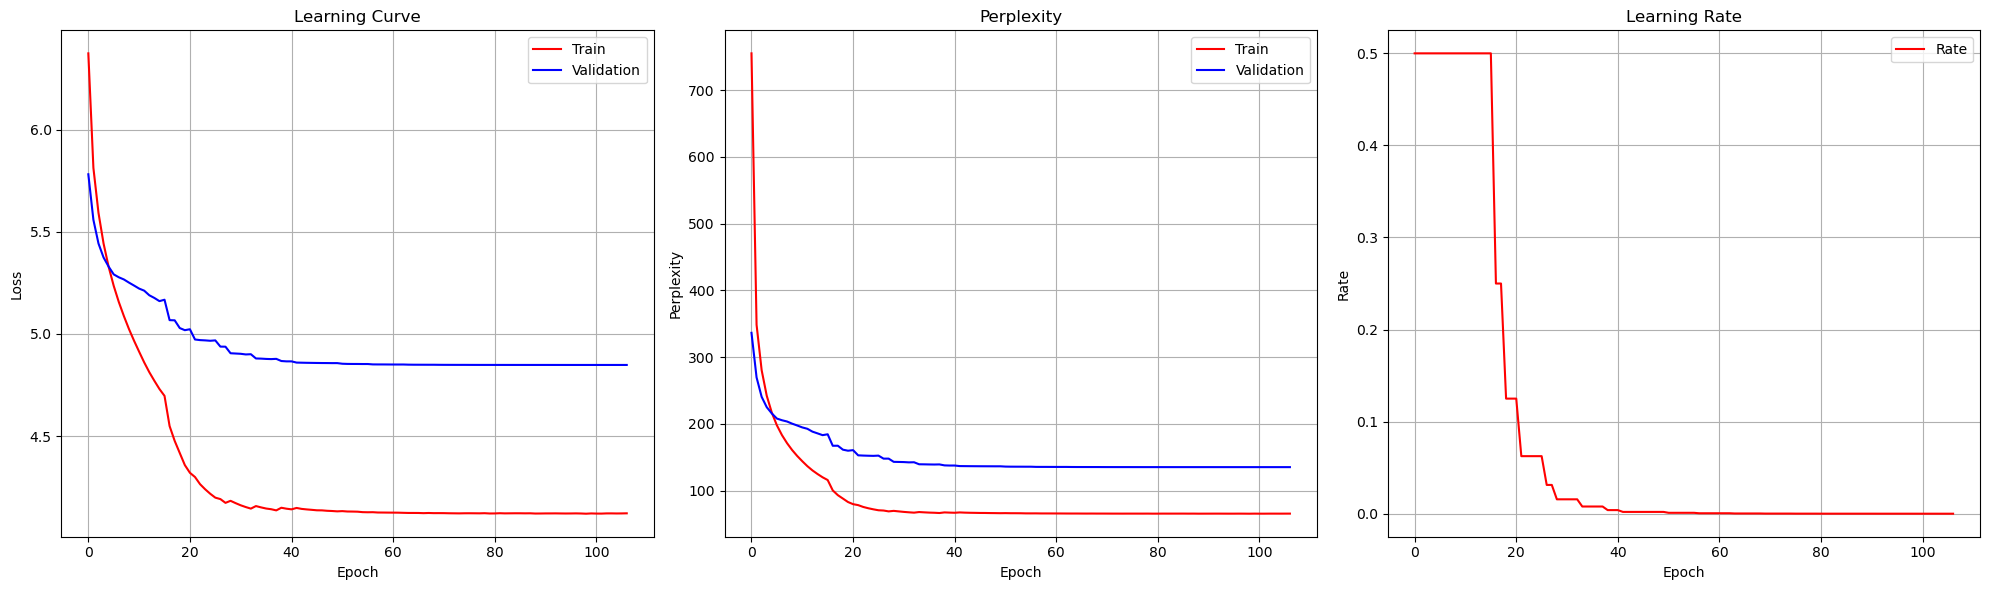

In [21]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [22]:
model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

/tmp/ipykernel_15991/1059837893.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input), torch.tensor(target)


Validation: Loss = 4.848 , Perplexity = 135.2
Test: Loss = 4.789 , Perplexity = 130.2


# Text Generation

In [23]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(33278, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33278, bias=True)
)

In [24]:
num_trainable_params(model)

39.323278

In [25]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [char2ind[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = findWordByToken(next_token_id)
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.5, 
                          model = model)

print(generated_text)

i think the movie is a very good poem , and that it is the only way to be the last to have a member of the original .
